<a href="https://colab.research.google.com/github/DimpleB0501/SecureNPrivateAIScholarshipCodes/blob/master/DeepLearningwithPyTorch/transferLearningKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing data from kaggle

In [0]:
from google.colab import files
files.upload() # Upload your downloaded kaggle.json file. Follow this post to understand shttps://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dimpleb","key":"3af391a58e83c364513f991661923719"}'}

In [0]:
!pip3 install -U -q kaggle
!rm -rf ~/.kaggle #Remove it if you already have it. Do it once to see the whole procedure
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


## Import dataset from kaggle competition
### This can be done by visiting the kaggle site https://www.kaggle.com/c/dogs-vs-cats/data and coping the command before Download all option and pasting it in the code cell.

In [0]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive/') #Follow the link copy the authorization code paste it in the blank cell and press enter

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Make a Cat_Dog_data folder to save your dataset there
import os
os.chdir('/content/drive/My Drive/AiScholarship/') #Replace /content/drive/My Drive/AiScholarship/ with /content/drive/My Drive/your_desiredpath to createfolder
!rm -rf Cat_Dog_data #If it exists remove it.Do only once to see the whole procedure
!mkdir Cat_Dog_data
!kaggle competitions download -c dogs-vs-cats -p /content/drive/My\ Drive//AiScholarship/Cat_Dog_data
!ls

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 11.7MB/s]
 94% 256M/271M [00:02<00:00, 106MB/s] 
100% 271M/271M [00:03<00:00, 92.1MB/s]
 99% 536M/543M [00:06<00:00, 74.2MB/s]
100% 543M/543M [00:06<00:00, 91.9MB/s]
 Cat_Dog_data
'Copy of fashionMnist.ipynb'
'Copy of transferLearningDatasetGit.ipynb'
 DataAugmentation.png
 dataLoader1.png
 edgeDetection.ipynb
 fashionMnist.ipynb
 Images
 layerWDropout.png
 MNISTwithPytorchAndColab.ipynb
 myAiScholarshipPart1.ipynb
 tech_helpImages
 trainNValidationLoss.png
 transferLearningDatasetGit.ipynb
 transferLearningDatasetKaggle_part1.ipynb
 transferLearningDatasetKaggle_part2.ipynb
 transferLearningKaggleDataset_part3.ipynb
 transferLearningKaggle.ipynb
 transforms.png
 turnoffdropoutModel.eval.png


In [0]:
# Unzip your folders
os.chdir('/content/drive/My Drive/AiScholarship/Cat_Dog_data/')
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/
!unzip -q train.zip -d train/  #unzip data in train/
!unzip -q test1.zip -d test/  #unzip data in test/

# Restructuring your data
As mentioned in the udacity course lectures all the dog images must be in the dog folder and similary for cat images based on torchvision datasetFolder documentationhttps://pytorch.org/docs/stable/torchvision/datasets.html
A generic data loader where the samples are arranged in this way:

For x label:

root/class_x/xxx.ext

root/class_x/xxy.ext

root/class_x/xxz.ext

For y label:

root/class_y/123.ext

root/class_y/nsdf3.ext

root/class_y/asd932_.ext



In [0]:
os.chdir('/content/drive/My Drive/AiScholarship/Cat_Dog_data/train/')
!mkdir dog
!mkdir cat

In [0]:
import shutil
pathToFiles = '/content/drive/My Drive/AiScholarship/Cat_Dog_data/train/train/'
newDestCat =  '/content/drive/My Drive/AiScholarship/Cat_Dog_data/train/cat/'
newDestDog =  '/content/drive/My Drive/AiScholarship/Cat_Dog_data/train/dog/'
for filename in os.listdir(pathToFiles):
  splitValue = filename.split(".", 1)
  if (splitValue[0] == "cat"):
    path = pathToFiles + filename
    newCatpath = newDestCat + filename
    shutil.move(path, newCatpath)
    
  if (splitValue[0] == "dog"):
    path = pathToFiles + filename
    newDogpath = newDestDog + filename
    shutil.move(path, newDogpath)

In [0]:
os.chdir('/content/drive/My Drive/AiScholarship/Cat_Dog_data/train/')
!rm -rf train #Delete the rtrain folder as it becomes redundant

# Implementing transfer learning

In [0]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
# This class used to apply transforms on the train dataset split into training and validation set. It is from https://stackoverflow.com/questions/56582246/correct-data-loading-splitting-and-augmentation-in-pytorch
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
        # yes, you don't need these 2 lines below :(
        if transform is None and target_transform is None:
            print("No transform applied :)")

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [0]:
# The train dataset is split into train and validation set (90:10 percent respectively) as the test set isnt in the desired format
os.chdir('/content/drive/My Drive/AiScholarship/Cat_Dog_data/')
data_dir = '/content/drive/My Drive/AiScholarship/Cat_Dog_data/'

# TODO: Define transforms for the training data and testing data

# Pass transforms in here, then run the next cell to see how the transforms look
train_dataset = datasets.ImageFolder(data_dir + '/train')

#split 90-10 percent for train and valid respectively
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = ApplyTransform(train_dataset, transform=train_transform)
valid_data = ApplyTransform(valid_dataset, transform=valid_transform)
test_data = datasets.ImageFolder(data_dir + '/test')

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [0]:
# Printing the length of the train, validation and test set
print(len(train_data))
print(len(valid_data))
print(len(test_data))

22500
2500
12500


In [0]:
# Define the model
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 30675370.40it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
# Training 
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()
            
torch.save(model, 'dogsNCatsTrain.pth')  

Epoch 1/1.. Train loss: 0.512.. Test loss: 0.195.. Test accuracy: 0.932
Epoch 1/1.. Train loss: 0.285.. Test loss: 0.065.. Test accuracy: 0.980
Epoch 1/1.. Train loss: 0.173.. Test loss: 0.063.. Test accuracy: 0.977
Epoch 1/1.. Train loss: 0.153.. Test loss: 0.074.. Test accuracy: 0.974
Epoch 1/1.. Train loss: 0.438.. Test loss: 0.052.. Test accuracy: 0.978
Epoch 1/1.. Train loss: 0.372.. Test loss: 0.075.. Test accuracy: 0.972
Epoch 1/1.. Train loss: 0.331.. Test loss: 0.212.. Test accuracy: 0.915
Epoch 1/1.. Train loss: 0.266.. Test loss: 0.087.. Test accuracy: 0.969
Epoch 1/1.. Train loss: 0.205.. Test loss: 0.069.. Test accuracy: 0.981
Epoch 1/1.. Train loss: 0.172.. Test loss: 0.052.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.196.. Test loss: 0.060.. Test accuracy: 0.977
Epoch 1/1.. Train loss: 0.372.. Test loss: 0.080.. Test accuracy: 0.968
Epoch 1/1.. Train loss: 0.166.. Test loss: 0.065.. Test accuracy: 0.975
Epoch 1/1.. Train loss: 0.167.. Test loss: 0.060.. Test accuracy

# Testing the classifier performance on random image from the test set

In [0]:
device = 'cuda'
model=torch.load('dogsNCatsTrain.pth')
model.eval()
#Creating a label dictionary
labelDict = {0: 'Cat', 1: 'Dog' } 

tensor([[-2.2221e-04, -8.4112e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
Prediction: Cat


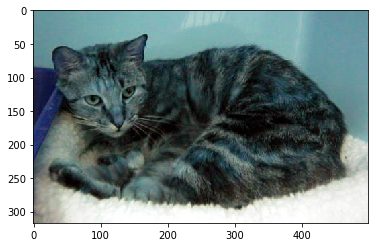

In [0]:
#Randomly selecting an image from the test_dataset folder
import os, random
import cv2

value = random.choice([x for x in os.listdir('/content/drive/My Drive/AiScholarship/Cat_Dog_data/test/test1') if os.path.isfile(os.path.join('/content/drive/My Drive/AiScholarship/Cat_Dog_data/test/test1', x))])
imagePath  = '/content/drive/My Drive/AiScholarship/Cat_Dog_data/test/test1/'+str(value)
image = cv2.imread(imagePath, 1)
plt.imshow(image)

from PIL import Image
ImageTransforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
image = Image.fromarray(image)
loadedImg = ImageTransforms(image) #Apply transforms to the loaded Image
loadedImg = loadedImg.unsqueeze(0) #Get it in proper dimension for the model
loadedImg = loadedImg.to(device)

out_predict = model(loadedImg)
print (out_predict)
pred = out_predict.max(1, keepdim=True)[1]
print ('Prediction:', labelDict[pred.item()])